# Linear algebra Homework assignment 3

In [2]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Problem 1 - 4

In [3]:
# [TODO]
def compute_lookat(azim: float, elev: float):
    """
        Compute the look at vector. (Definition in Figure 3)
        azim: float, degree in [-180, 180],
        elev: float, degree in [-180, 180]
    """

    # For the definition of azim and elev, check
    # https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html

    azim_rad = np.radians(azim)
    elev_rad = np.radians(elev)

    a = np.cos(elev_rad) * np.sin(azim_rad)
    b = -np.sin(elev_rad)
    c = np.cos(elev_rad) * np.cos(azim_rad)
    
    lookat = np.array([a, b, c])
    return lookat / np.linalg.norm(lookat)

In [4]:
# [TODO]
def compute_normal(P1: tuple, P2: tuple, P3: tuple):
    """
        Compute the normal vector, given P1, P2, P3 in counter-clockwise order.
    """

    P1, P2, P3 = np.array(P1), np.array(P2), np.array(P3)
    v1 = P2 - P1 
    v2 = P3 - P1 
    normal = np.cross(v1, v2)
    return normal / np.linalg.norm(normal)

In [5]:
# [TODO]
def visible(face_normal: np.ndarray, lookat: np.ndarray):
    """
        Given a normal vector of a face, determine if the face (outward-facing side) is visible
    """

    # use the normal vector of the triangle and the lookat direction
    # to determine the visibility.
    return np.dot(face_normal, lookat) < 0


In [6]:
# [TODO] compute the beta in Figure3
def compute_intensity(face_normal: np.ndarray, lookat: np.ndarray, lightsource: np.ndarray):
    """
        Given normal vector of a face (face_normal), viewing vector (lookat) and lightsource (lightsource),
        compute the specular intensity.
    """
    face_normal = face_normal / np.linalg.norm(face_normal)
    lookat = lookat / np.linalg.norm(lookat)
    lightsource = lightsource / np.linalg.norm(lightsource)
    reflect = 2 * np.dot(face_normal, lightsource) * face_normal - lightsource
    reflect = reflect / np.linalg.norm(reflect)
    intensity = max(0, np.dot(reflect, -lookat))
    
    return intensity

## Problem 5
Perform at least two tasks from the following list, and describe what you have done

- Change a model (please choose a convex object).
- Give each face of the model a different color.
- Change the movemnt of the light source.
- Other interesting changes

In [7]:
def read_obj_file(file_path):
    vertices = []
    faces = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertex = list(map(float, line.strip().split()[1:]))
                vertices.append(vertex)
            elif line.startswith('f '):
                face = [int(index.split('/')[0]) for index in line.strip().split()[1:]]
                faces.append(face)

    return np.array(vertices), np.array(faces)

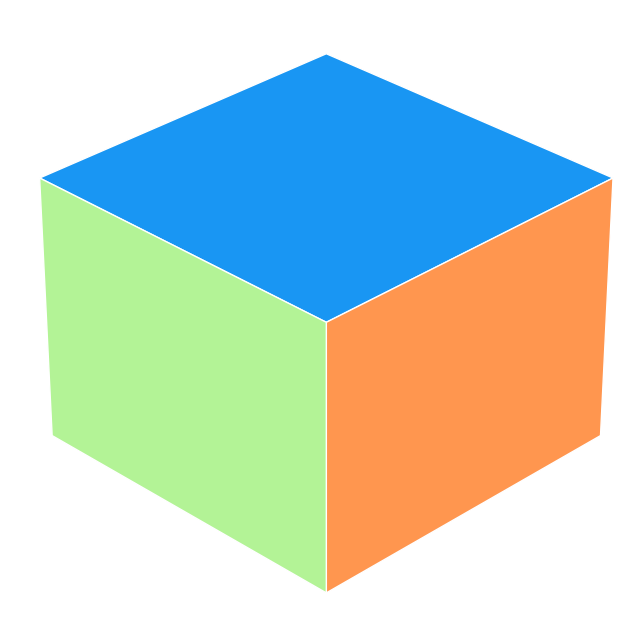

In [8]:
# vertices, faces = read_obj_file('icosahedron_modified.obj')
vertices, faces = read_obj_file('HW3_inputQ5.obj')

def plot_icosahedron(vertices, faces):
    faces = faces - 1
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    ax.view_init(azim=45, elev=30)
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(faces)))
    
    face_colors = []
    for i, face in enumerate(faces):
        verts = vertices[face]
        normal = compute_normal(verts[0], verts[1], verts[2])
        face_colors.append(colors[i])
    
    poly3d = Poly3DCollection([vertices[face] for face in faces])
    poly3d.set_facecolors(face_colors)
    poly3d.set_edgecolor('white')
    ax.add_collection3d(poly3d)
    
    all_points = np.vstack([vertices[face] for face in faces])
    x_min, x_max = all_points[:,0].min(), all_points[:,0].max()
    y_min, y_max = all_points[:,1].min(), all_points[:,1].max()
    z_min, z_max = all_points[:,2].min(), all_points[:,2].max()
    
    max_range = max(x_max-x_min, y_max-y_min, z_max-z_min)
    mid_x = (x_max + x_min) * 0.5
    mid_y = (y_max + y_min) * 0.5
    mid_z = (z_max + z_min) * 0.5
    
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

plot_icosahedron(vertices, faces)

studentID = '110062272'  # replace to your own studentID!
fname = f'HW3_{studentID}.png'
plt.savefig(fname)

## Problem 6
There is a type of terms, called **vn** (vertex normal), in the obj file.
However, it record vn as each

Please look up the definition of vertex normal and implement it accordingly. The OBJ
file with the corrected vertex normals is icosahedron modified.obj.

In [9]:
from collections import defaultdict

def load_obj(file_path):
    vertices = []
    faces = []
    vertex_normals = []

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            values = line.split()
            if not values:
                continue

            if values[0] == 'v':
                vertices.append([float(x) for x in values[1:4]])
            elif values[0] == 'vn':
                vertex_normals.append([float(x) for x in values[1:4]])
            elif values[0] == 'f':
                vertex_indices = []
                normal_indices = []

                for vertex in values[1:]:
                    if '//' in vertex:
                        v_idx, _, n_idx = vertex.split('/')
                        vertex_indices.append(int(v_idx) - 1)  
                        normal_indices.append(int(n_idx) - 1)
                    else:
                        vertex_indices.append(int(vertex) - 1)

                faces.append(vertex_indices)  

    return np.array(vertices), np.array(faces), np.array(vertex_normals)

In [10]:
# [TODO]
def compute_vertex_normals(vertices, faces):
    
    vertex_normals = np.zeros_like(vertices)
    vertex_counts = np.zeros(len(vertices))
    ######## write you code below
    for face in faces:
        v1, v2, v3 = vertices[face[0]], vertices[face[1]], vertices[face[2]]
        face_normal = compute_normal(v1, v2, v3)
        
        for vertex_idx in face:
            vertex_normals[vertex_idx] += face_normal
            vertex_counts[vertex_idx] += 1
    
    for i in range(len(vertex_normals)):
        if vertex_counts[i] > 0:
            vertex_normals[i] = vertex_normals[i] / vertex_counts[i]
            vertex_normals[i] = vertex_normals[i] / np.linalg.norm(vertex_normals[i])
    #########

    return vertex_normals

In [11]:
obj_path = "icosahedron_modified.obj"
vertices, faces, vn = load_obj(obj_path)
vertex_normals = compute_vertex_normals(vertices, faces)

# print("vertex normal：")
# for i, normal in enumerate(vertex_normals):
#     print(f"v{i+1:02d} normal: [{normal[0]:.6f}, {normal[1]:.6f}, {normal[2]:.6f}]")

if (np.allclose(vertex_normals, vn)):
    print("PASS")
else :
    print("ERROR")

PASS
